for vision problems, PyTorch provides torchvision, which allows you to avoid writing boilerplate code

the tutorial will use the CIFAR-10 image dataset

In order to train an image classifier, we
1. Download the CIFAR10 images and adjust them (normalize) so they're easier for the network to work with
2. Create a convolutional neural network that can learn to classify images.
3. Choose a way to measure how well the network's predictions match the true labels (defining a loss function)
4. Use the training images to teach the network, updating its weights based on the loss (traning the network on training data)
5. Check how well the network performs on a separate set of images it hasn't seen before (testing the network on test data)





In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# passing in the transform we created in the first line into the dataset
# notice how we set enable the train parameter
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:02<00:00, 61.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


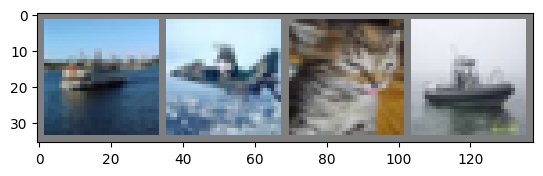

ship  plane cat   ship 


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def show_img(img):
  img = img / 2 + 0.5 # unnormalizing the image
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# load random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show_img(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Defining a Convolutional Neural that takes 3-channel (3 channels for r, g, and b) images

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # notice the 1st parameter (number of channels) has been changed to 3 rather than 1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

defining a loss function \\
with Classification Cross-Entropy loss and SGD with momentum

In [24]:
import torch.optim as optim
import torch.nn

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

training the network


In [25]:
for epoch in range(2):  # Repeat the whole training process for 2 epochs (complete passes through the dataset)

    running_loss = 0.0  # keeps track of the loss over a set of mini-batches

    # Loop over the training data in mini-batches
    for i, data in enumerate(trainloader, 0):
        # Each 'data' is a mini-batch containing:
        #   inputs: a batch of images
        #   labels: the correct class labels for these images
        inputs, labels = data

        # Reset the gradients for all parameters before processing the current mini-batch
        optimizer.zero_grad()

        # MAKE A PREDICTION: Forward pass: run the inputs through the network to get predictions
        outputs = net(inputs)

        # MEASURE ERROR: Compute the loss (how far the predictions are from the actual labels)
        loss = criterion(outputs, labels)

        # LEARN FROM MISTAKES: Backward pass: calculate the gradients (partial derivatives of loss with respect to each parameter)
        loss.backward()

        # IMPROVE: Update the network parameters (weights and biases) using the computed gradients
        optimizer.step()

        # Accumulate the loss value (convert loss tensor to a Python number with loss.item())
        running_loss += loss.item()

        # Every 2000 mini-batches, print the average loss over those batches to monitor progress
        if i % 2000 == 1999:  # When the index is 1999, 3999, etc.
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0  # Reset running_loss for the next set of mini-batches

print('Finished Training')


[1,  2000] loss: 2.150
[1,  4000] loss: 1.851
[1,  6000] loss: 1.673
[1,  8000] loss: 1.565
[1, 10000] loss: 1.515
[1, 12000] loss: 1.449
[2,  2000] loss: 1.374
[2,  4000] loss: 1.356
[2,  6000] loss: 1.324
[2,  8000] loss: 1.319
[2, 10000] loss: 1.295
[2, 12000] loss: 1.248
Finished Training


saving the trained model

In [26]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Testing the network on testing data

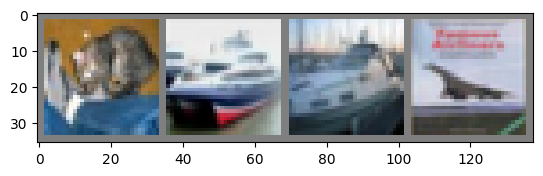

GroundTruth:  cat   ship  ship  plane


In [28]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show_img(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [29]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True)) # Load the saved model weights (parameters) from the file at PATH into the network

<All keys matched successfully>

checking what the network thinks

In [35]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   plane


looking at how the network performs on the entire dataset

In [36]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


Viewing the performance of different classes

In [37]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.9 %
Accuracy for class: car   is 76.5 %
Accuracy for class: bird  is 38.0 %
Accuracy for class: cat   is 33.1 %
Accuracy for class: deer  is 52.0 %
Accuracy for class: dog   is 42.2 %
Accuracy for class: frog  is 68.4 %
Accuracy for class: horse is 74.7 %
Accuracy for class: ship  is 45.1 %
Accuracy for class: truck is 53.7 %
